# Sentiment Analysis
# Analyzing Reddit’s Climate Change Discourse: A Distributed Study of Topic Modeling and Sentiment Analysis Techniques
## ST446 Group Project
### Candidate Nrs: 39884, 48099, 49308, 50250

In [ ]:
# Import libraries used in this notebook
import zipfile
import os
import re
import hashlib
from datetime import datetime
import numpy as np
import pandas as pd
import string
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from time import time
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import time
from scipy.stats import zscore

from pyspark.sql import SparkSession
import pyspark.sql.functions as sql_f
from pyspark.sql.functions import udf, col, when, lower, regexp_replace, size, from_unixtime, to_date  
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, ArrayType

from pyspark.ml.feature import StopWordsRemover, Tokenizer, CountVectorizer, IDF
from pyspark.ml.clustering import LDA
from pyspark.ml.linalg import Vectors, DenseVector
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

## Data Loading & Pre-Processing

- Downloaded the Reddit Climate Change dataset from Kaggle as a ZIP file using the Kaggle API.
- Unzipped the archive to extract the comments CSV file.
- Uploaded the `the-reddit-climate-change-dataset-comments.csv` file to HDFS, replacing any previous version.
- Verified the successful upload by listing the contents of the HDFS root directory.

In [2]:
# 1. Download the Kaggle dataset zip
!curl -L -o climate.zip \
    "https://www.kaggle.com/api/v1/datasets/download/pavellexyr/the-reddit-climate-change-dataset"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1536M  100 1536M    0     0  40.6M      0  0:00:37  0:00:37 --:--:-- 43.2M


In [ ]:
# 2. Unzip it 
!unzip -o climate.zip

# 3. Remove any old copy in HDFS and put the comments file there
!hadoop fs -rm -f /the-reddit-climate-change-dataset-comments.csv
!hadoop fs -put the-reddit-climate-change-dataset-comments.csv /

# 4. Verify upload
!hadoop fs -ls /

Archive:  climate.zip
  inflating: the-reddit-climate-change-dataset-comments.csv  
  inflating: the-reddit-climate-change-dataset-posts.csv  
Found 4 items
-rw-r--r--   2 root hadoop 4111000325 2025-05-01 19:29 /the-reddit-climate-change-dataset-comments.csv
drwxrwxrwt   - hdfs hadoop          0 2025-05-01 19:25 /tmp
drwxrwxrwt   - hdfs hadoop          0 2025-05-01 19:27 /user
drwxrwxrwt   - hdfs hadoop          0 2025-05-01 19:23 /var


In [4]:
# point to the new HDFS path
comments_path = "hdfs://st446-cluster-project-m:8020/the-reddit-climate-change-dataset-comments.csv"

### Load Dataset into Spark

Below, we define a custom schema to properly parse the Reddit comments CSV file. This ensures correct data types and handles multiline fields. We then load the dataset into a Spark DataFrame using this schema, and display the schema and a preview of the first five rows to verify successful loading.

In [ ]:
# define the schema for the comments file

schema = StructType([
    StructField("type",           StringType(), True),
    StructField("id",             StringType(), True),
    StructField("subreddit.id",   StringType(), True),
    StructField("subreddit.name", StringType(), True),
    StructField("subreddit.nsfw", StringType(), True),
    StructField("created_utc",    StringType(), True),
    StructField("permalink",      StringType(), True),
    StructField("body",           StringType(), True),
    StructField("sentiment",      DoubleType(), True),
    StructField("score",          IntegerType(),True)
])

df = spark.read \
    .option("header", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .schema(schema) \
    .csv(comments_path)

# print schema and show first 5 rows for verification 
df.printSchema()
df.show(5)

root
 |-- type: string (nullable = true)
 |-- id: string (nullable = true)
 |-- subreddit.id: string (nullable = true)
 |-- subreddit.name: string (nullable = true)
 |-- subreddit.nsfw: string (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- body: string (nullable = true)
 |-- sentiment: double (nullable = true)
 |-- score: integer (nullable = true)



+-------+-------+------------+--------------+--------------+-----------+--------------------+--------------------+---------+-----+
|   type|     id|subreddit.id|subreddit.name|subreddit.nsfw|created_utc|           permalink|                body|sentiment|score|
+-------+-------+------------+--------------+--------------+-----------+--------------------+--------------------+---------+-----+
|comment|imlddn9|       2qh3l|          news|         false| 1661990368|https://old.reddi...|Yeah but what the...|   0.5719|    2|
|comment|imldbeh|       2qn7b|          ohio|         false| 1661990340|https://old.reddi...|Any comparison of...|  -0.9877|    2|
|comment|imldado|       2qhma|    newzealand|         false| 1661990327|https://old.reddi...|I'm honestly wait...|  -0.1143|    1|
|comment|imld6cb|       2qi09|    sacramento|         false| 1661990278|https://old.reddi...|Not just Sacramen...|      0.0|    4|
|comment|imld0kj|       2qh1i|     askreddit|         false| 1661990206|https://old

### Sentiment Analysis Prep
For sentiment modeling, I remove the rows that are null for the sentiment column. Then, I add a sentiment class column that puts the sentiment score into three categories - positive, negative, and neutral.

In [ ]:
null_count = df.filter(col("sentiment").isNull()).count()
print(f"Number of null labels: {null_count}")

# Removes rows with null values for sentiment
df = df.filter(col("sentiment").isNotNull())

# add a column for the sentiment categories for modeling
df = df.withColumn(
    "sentiment_class",
    when(df["sentiment"] > 0.35, 2) #positive
    .when(df["sentiment"] < -0.35, 0) #negative
    .otherwise(1) #neutral
)

# adds a column with the category name for visualizations
df = df.withColumn(
    "sentiment_label",
    when(df.sentiment_class == 0, "Negative")
    .when(df.sentiment_class == 1, "Neutral")
    .when(df.sentiment_class == 2, "Positive")
)

Number of null labels: 57131


### Custom Stopwords List

We created a comprehensive custom stopwords list to remove domain-specific noise and irrelevant tokens from the Reddit comments. This list includes common HTML and LaTeX markup, URL fragments, mathematical symbols, generic formatting terms, and uninformative words often found in web-scraped or user-generated content. Including this alongside standard stopwords helps improve the quality of downstream topic modeling.

In [ ]:
custom_stopwords = set([
    "lt", "gt", "ref", "quot", "cite", "br", "amp", "https", "http", "urlhttps", "urlhttp", 
    "file", "image", "jpg", "png", "gif", "svg", "thumb", "px", "category", "url", "external", 
    "link", "source", "web", "cite", "reference", "reflist", "main", "article", "seealso", 
    "further", "infobox", "template", "navbox", "redirect", "harvnb", "isbn", "doi", "pmid", 
    "ssrn", "jstor", "bibcode", "arxiv", "ol", "hdl", "wikidata", "wiki", "math", "sup", "sub", 
    "nbsp", "equation", "displaystyle", "begin", "end", "left", "right", "sqrt", "frac", "sum", 
    "prod", "int", "lim", "rightarrow", "infty", "alpha", "beta", "gamma", "delta", "epsilon", 
    "zeta", "eta", "theta", "iota", "kappa", "lambda", "mu", "nu", "xi", "omicron", "pi", "rho", 
    "sigma", "tau", "upsilon", "phi", "chi", "psi", "omega", "mathrm", "mathbb", "mathcal", 
    "mathbf", "cdots", "ldots", "vdots", "ddots", "forall", "exists", "in", "ni", "subset", 
    "subseteq", "supset", "supseteq", "emptyset", "cap", "cup", "setminus", "not", "times", 
    "div", "cdot", "pm", "mp", "oplus", "otimes", "odot", "leq", "geq", "neq", "approx", 
    "aligncenter", "fontsize", "alignright", "alignleft", "textalign", "bold", "italic", 
    "underline", "strikethrough", "lineheight", "padding", "margin", "width", "height", "float", 
    "clear", "border", "background", "color", "font", "family", "size", "weight", "style", 
    "decoration", "verticalalign", "textindent", "pre-wrap", "nowrap", "valign", "bgcolor", 
    "style", "class", "id", "width", "height", "align", "border", "cellpadding", "cellspacing", 
    "colspan", "rowspan", "nowrap", "target", "rel", "hreflang", "title", "alt", "src", "dir", 
    "lang", "type", "name", "value", "readonly", "multiple", "onclick", "onmousedown", 
    "onmouseup", "onmouseover", "onmouseout", "onload", "onunload", "onsubmit", "onreset", 
    "onfocus", "onblur", "onkeydown", "onkeyup", "onkeypress", "onerror", "infobox", "caption", 
    "cite", "dmy", "mdy",
    "date", "archive", "www", "com", "org", "access", "ndash", "sfn", "dts", "vauthors", "mvar", 
    "ipaslink", "ipa", "iii", "ibn", "first", "last", "also", "html", "use", "publisher", "year", "one", 
    "page", "new", "trek", "ipablink", "similar", "usual", "two", "abbr", "used", "est", "ibm", "first1",
    "first2", "last1", "last2", "free", "pdf"
])

### Preprocessing and Tokenization

- Sampled 20% of the original Reddit comments (921500 comments) for faster processing.
- Performed basic text cleaning: converted text to lowercase, removed URLs, non-alphabetic characters, and extra whitespace.
- Tokenized the cleaned text into individual words.
- Removed both default English stopwords and our custom stopwords to eliminate uninformative tokens.
- Filtered out very short tokens (≤2 characters) to further reduce noise and keep meaningful words only.

In [ ]:
# Draw a 20% sample of the raw comments
sample_df = df.sample(withReplacement=False, fraction=0.2, seed=42)
print(f"Sample size: {sample_df.count()} comments")

# Clean text on the sample
df_clean = (
    sample_df
      .withColumn("body_clean", lower(col("body")))
      .withColumn("body_clean", regexp_replace("body_clean", r"http\S+", ""))  
      .withColumn("body_clean", regexp_replace("body_clean", r"[^a-z\s]", " "))  
      .withColumn("body_clean", regexp_replace("body_clean", r"\s+", " "))     
)

# Tokenize
tokenizer = Tokenizer(inputCol="body_clean", outputCol="tokens")
df_tokens = tokenizer.transform(df_clean)

# 3. Remove stopwords
default_stops = StopWordsRemover.loadDefaultStopWords("english")
combined_stops = list(set(default_stops) | custom_stopwords)

remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="filtered",
    stopWords=combined_stops
)
df_no_stop = remover.transform(df_tokens)

# Filter out very short tokens
min_len = udf(lambda toks: [t for t in toks if len(t) > 2], ArrayType(StringType()))
df_final = df_no_stop.withColumn("final_tokens", min_len(col("filtered")))

# Inspect
df_final.select("body_clean", "final_tokens").show(5)

Sample size: 909980 comments


+--------------------+--------------------+
|          body_clean|        final_tokens|
+--------------------+--------------------+
|they need to chan...|[need, change, la...|
| gt not climate c...|[climate, change,...|
|you have no real ...|[real, solution, ...|
|i m sure it s cli...|[sure, climate, c...|
|yeah i remember a...|[yeah, remember, ...|
+--------------------+--------------------+
only showing top 5 rows



### Count Vectorization & IDF

Applied `CountVectorizer` to convert the cleaned and tokenized text into a sparse vector representation. This step transforms the text into numerical features based on token frequency:

The result is stored in the `rawFeatures` column and will be used as input for topic modeling.

IDF (Inverse Document Frequency) transformer was applied to scale down the influence of common terms, resulting in the final TF-IDF feature vectors used as input for classification models.

In [ ]:
# Count Vectorize
cv = CountVectorizer(
    inputCol="final_tokens",
    outputCol="rawFeatures",
    minDF=50
)
cv_model = cv.fit(df_final)
df_tf = cv_model.transform(df_final)

# IDF
idf = IDF(
    inputCol="rawFeatures",
    outputCol="features"
)
idf_model = idf.fit(df_tf)
df_tfidf = idf_model.transform(df_tf)

# Sentiment Analysis Modeling

### Preparation for Modeling
- Visualized the count of comments by sentiment class
- Split data into training and testing sets (80/20)
- Repartitioned training data for parallel processing
- Printed number of comments and partions

In [10]:
df_tfidf.groupBy("sentiment_label").count().orderBy("sentiment_label").show()

+---------------+------+
|sentiment_label| count|
+---------------+------+
|       Negative|335699|
|        Neutral|244084|
|       Positive|330197|
+---------------+------+



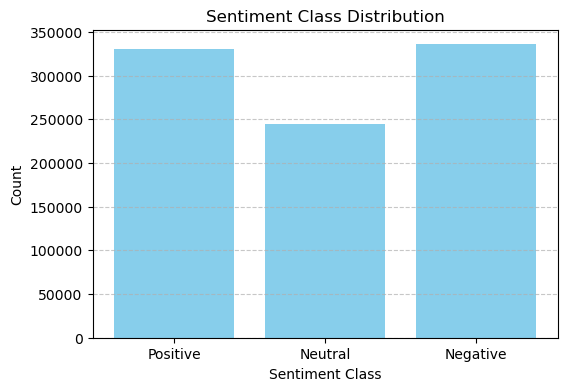

In [ ]:
# Get class distribution counts to pandas for visualization
class_dist = df_tfidf.groupBy("sentiment_label").count().toPandas()

# Plot Distributions
plt.figure(figsize=(6,4))
plt.bar(class_dist["sentiment_label"], class_dist["count"], color='skyblue')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.xticks(class_dist["sentiment_label"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:
train_data, test_data = df_tfidf.randomSplit([0.8, 0.2], seed=121)

In [14]:
train_data = train_data.repartition(8)

In [23]:
print("Number of Training Comments: ", train_data.count())
print("Number of Testing Comments: ", test_data.count())

Number of Training Comments:  727553


Number of Testing Comments:  182427


In [24]:
print(f"Train partitions: {train_data.rdd.getNumPartitions()}")
print(f"Test partitions:  {test_data.rdd.getNumPartitions()}")
print('Number of Workers:', sc._conf.get('spark.executor.instances'))

Train partitions: 8
Test partitions:  1
Number of Workers: 2


### Logisitic Regression Without Tuning

In [ ]:
# LR model with no tuning
log = LogisticRegression(featuresCol = "features", labelCol = "sentiment_class")

start_time = time.time()
model_log = log.fit(train_data)
fit_time_lr = time.time() - start_time

In [ ]:
# Evaluate model using test data
start_time = time.time()
predictions_log = model_log.transform(test_data)
predict_time_lr = time.time() - start_time

In [18]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions_log)

25/04/30 15:04:16 WARN DAGScheduler: Broadcasting large task binary with size 1487.1 KiB


In [19]:
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="f1"
)
f1 = evaluator_f1.evaluate(predictions_log)

25/04/30 15:04:27 WARN DAGScheduler: Broadcasting large task binary with size 1487.1 KiB


In [20]:
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = evaluator_precision.evaluate(predictions_log)

25/04/30 15:04:37 WARN DAGScheduler: Broadcasting large task binary with size 1487.1 KiB


In [21]:
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = evaluator_recall.evaluate(predictions_log)

25/04/30 15:04:46 WARN DAGScheduler: Broadcasting large task binary with size 1487.1 KiB


In [22]:
print("Logistic Regression Results")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

Logistic Regression Results
Accuracy:  0.7499
F1 Score:  0.7513
Precision: 0.7533
Recall:    0.7499


In [23]:
print(f"Logistic Regression Training Time: {fit_time_lr:.2f} seconds")
print(f"Logistic Regression Prediction Time: {predict_time_lr:.2f} seconds")

Logistic Regression Training Time: 183.59 seconds
Logistic Regression Prediction Time: 0.09 seconds


### Logisitic Regression with Parameter Tuning

In [15]:
# LR Model
lr = LogisticRegression(featuresCol="features", labelCol="sentiment_class")

# Param grid
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.0, 0.1])
             .addGrid(lr.elasticNetParam, [0.0, 0.5])
             .addGrid(lr.maxIter, [50, 100])
             .build())

# Evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="f1"
)

from pyspark.ml.tuning import TrainValidationSplit

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8,
                           parallelism=2)



# Fit & Timing
start_time = time.time()
cv_model = tvs.fit(train_data)
lr_tuning_duration = time.time() - start_time

# Best model
best_model = cv_model.bestModel
print("Best Reg Param:", best_model._java_obj.getRegParam())
print("Best ElasticNet Param:", best_model._java_obj.getElasticNetParam())
print("Best Max Iter:", best_model._java_obj.getMaxIter())

Best Reg Param: 0.0
Best ElasticNet Param: 0.0
Best Max Iter: 50


In [16]:
# Evaluate model using test data
start_time = time.time()
predictions_log = best_model.transform(test_data)
tuning_predict_lr = time.time() - start_time

In [17]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions_log)

25/05/01 20:07:52 WARN DAGScheduler: Broadcasting large task binary with size 1471.7 KiB


In [18]:
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="f1"
)
f1 = evaluator_f1.evaluate(predictions_log)

25/05/01 20:11:36 WARN DAGScheduler: Broadcasting large task binary with size 1471.7 KiB


In [19]:
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = evaluator_precision.evaluate(predictions_log)

25/05/01 20:16:17 WARN DAGScheduler: Broadcasting large task binary with size 1471.7 KiB


In [20]:
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = evaluator_recall.evaluate(predictions_log)

25/05/01 20:20:37 WARN DAGScheduler: Broadcasting large task binary with size 1471.7 KiB


In [21]:
print("Tuned Logistic Regression Results")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

Tuned Logistic Regression Results
Accuracy:  0.7499
F1 Score:  0.7513
Precision: 0.7533
Recall:    0.7499


In [22]:
print(f"Logistic Regression with Tuning Training Time: {lr_tuning_duration:.2f} seconds")
print(f"Logistic Regression with Tuning Prediction Time: {tuning_predict_lr:.2f} seconds")

Logistic Regression with Tuning Training Time: 1536.44 seconds
Logistic Regression with Tuning Prediction Time: 0.07 seconds


### Naive Bayes Without Tuning

In [ ]:
# NB without tuning
nb = NaiveBayes(labelCol="sentiment_class", featuresCol="features", modelType="multinomial")

start_time = time.time()
model_nb = nb.fit(train_data)
fit_time_nb = time.time() - start_time

In [ ]:
# Evaluate model using test data
start_time = time.time()
predictions_nb = model_nb.transform(test_data)
predict_time_nb = time.time() - start_time

In [26]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions_nb)

25/04/30 15:10:40 WARN DAGScheduler: Broadcasting large task binary with size 1481.9 KiB


In [27]:
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="f1"
)
f1 = evaluator_f1.evaluate(predictions_nb)

25/04/30 15:10:58 WARN DAGScheduler: Broadcasting large task binary with size 1481.9 KiB


In [28]:
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = evaluator_precision.evaluate(predictions_nb)

25/04/30 15:11:07 WARN DAGScheduler: Broadcasting large task binary with size 1481.9 KiB


In [29]:
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = evaluator_recall.evaluate(predictions_nb)

25/04/30 15:11:16 WARN DAGScheduler: Broadcasting large task binary with size 1481.9 KiB


In [30]:
print("Naive Bayes Results")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

Naive Bayes Results
Accuracy:  0.5345
F1 Score:  0.5422
Precision: 0.5723
Recall:    0.5345


In [31]:
print(f"Naive Bayes Training Time: {fit_time_nb:.2f} seconds")
print(f"Naive Bayes Prediction Time: {predict_time_nb:.2f} seconds")

Naive Bayes Training Time: 35.55 seconds
Naive Bayes Prediction Time: 0.08 seconds


### Naive Bayes With Tuning

In [ ]:
# NB model
nb = NaiveBayes(labelCol="sentiment_class", featuresCol="Features", modelType="multinomial")

# Parameter grid for tuning smoothing 
paramGrid = (ParamGridBuilder()
             .addGrid(nb.smoothing, [0.5, 1.0, 2.0])
             .build())

# Evaluated based on f1 score
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="f1"
)

# CV with 3 folds
cv = CrossValidator(estimator=nb,
                    estimatorParamMaps=paramGrid,
                    evaluator= evaluator,
                    numFolds=3)

# Fit the model
start_time = time.time()
cv_model_nb = cv.fit(train_data)
nb_tuning_duration = time.time() - start_time

# Best model
best_model_nb = cv_model_nb.bestModel
best_smoothing = best_model_nb._java_obj.getSmoothing()
print(f"Best smoothing value: {best_smoothing}")

25/04/30 15:14:29 WARN DAGScheduler: Broadcasting large task binary with size 1507.8 KiB
25/04/30 15:14:58 WARN DAGScheduler: Broadcasting large task binary with size 1507.8 KiB
25/04/30 15:15:24 WARN DAGScheduler: Broadcasting large task binary with size 1507.8 KiB
25/04/30 15:18:01 WARN DAGScheduler: Broadcasting large task binary with size 1507.9 KiB
25/04/30 15:18:27 WARN DAGScheduler: Broadcasting large task binary with size 1507.9 KiB
25/04/30 15:18:43 WARN DAGScheduler: Broadcasting large task binary with size 1507.9 KiB
25/04/30 15:20:43 WARN DAGScheduler: Broadcasting large task binary with size 1507.8 KiB
25/04/30 15:21:05 WARN DAGScheduler: Broadcasting large task binary with size 1507.8 KiB
25/04/30 15:21:19 WARN DAGScheduler: Broadcasting large task binary with size 1507.8 KiB


Best smoothing value: 2.0


In [33]:
start_time = time.time()
predictions_nb = best_model_nb.transform(test_data)
tuning_predict_nb = time.time() - start_time

In [34]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions_nb)

25/04/30 15:24:35 WARN DAGScheduler: Broadcasting large task binary with size 1481.9 KiB


In [35]:
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="f1"
)
f1 = evaluator_f1.evaluate(predictions_nb)

25/04/30 15:24:49 WARN DAGScheduler: Broadcasting large task binary with size 1481.9 KiB


In [36]:
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = evaluator_precision.evaluate(predictions_nb)

25/04/30 15:24:59 WARN DAGScheduler: Broadcasting large task binary with size 1481.9 KiB


In [37]:
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="sentiment_class",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = evaluator_recall.evaluate(predictions_nb)

25/04/30 15:25:06 WARN DAGScheduler: Broadcasting large task binary with size 1481.9 KiB


In [38]:
print("Naive Bayes With Tuning Results")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

Naive Bayes With Tuning Results
Accuracy:  0.5535
F1 Score:  0.5593
Precision: 0.6070
Recall:    0.5535


In [39]:
print(f"Naive Bayes with Tuning Training Time: {nb_tuning_duration:.2f} seconds")
print(f"Naive Bayes with Tuning Prediction Time: {tuning_predict_nb:.2f} seconds")

Naive Bayes with Tuning Training Time: 596.71 seconds
Naive Bayes with Tuning Prediction Time: 0.06 seconds


## Sentiment Analysis Over Time
- Visualize sentiment comment trends per day
- Visualize normalized sentiment proportions over time
- Identify spike days using z scores
- Determine which sentiment was dominant each day

In [ ]:
# convert timestamps to date
df_time = df_tfidf.withColumn("date", to_date(from_unixtime(df_tfidf["created_utc"])))

In [ ]:
# group by date and label
sentiment_trend = df_time.groupBy("date", "sentiment_label").count().orderBy("date")

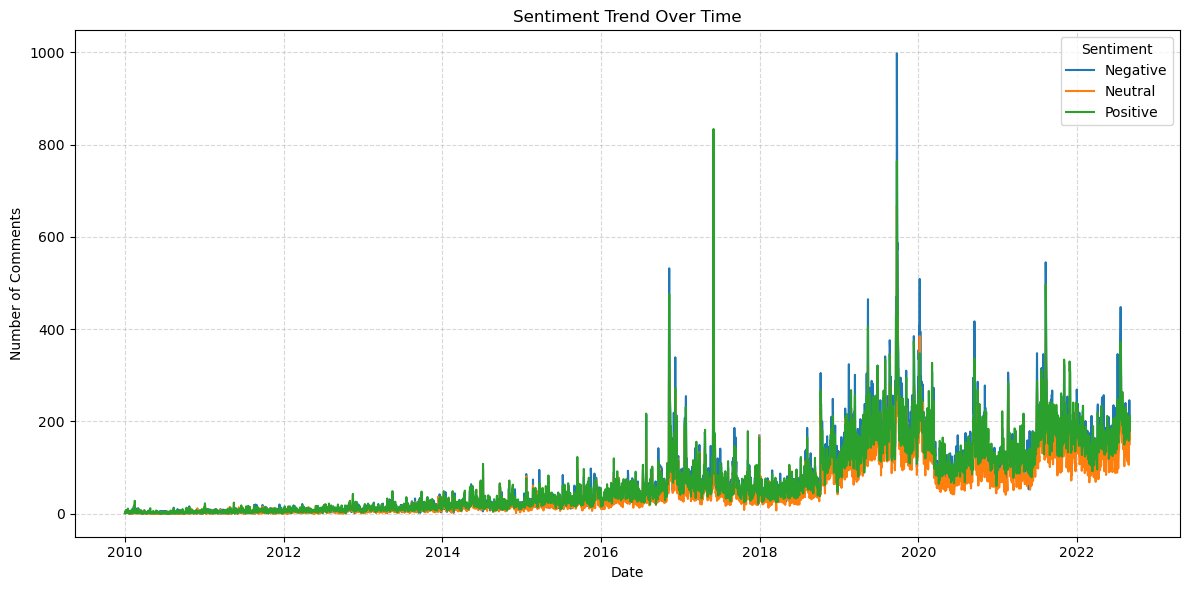

In [ ]:
trend_pd = sentiment_trend.toPandas()

# Pivot so sentiment classes is the column
pivoted = trend_pd.pivot(index='date', columns='sentiment_label', values='count').fillna(0)

# Plot
pivoted.plot(figsize=(12, 6))
plt.title("Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

In [ ]:
pivoted_spikes = pivoted

# Sum across all sentiment labels to get total sentiment activity
pivoted_spikes["total_comments"] = pivoted_spikes.sum(axis=1)
pivoted_spikes["z_score"] = zscore(pivoted_spikes["total_comments"])
pivoted_spikes["is_spike"] = pivoted_spikes["z_score"].abs() > 3.0

In [ ]:
# get ratios of different classes based on the total comments
pivoted_spikes["neg_ratio"] = pivoted_spikes["Negative"] / pivoted_spikes["total_comments"]
pivoted_spikes["neu_ratio"] = pivoted_spikes["Neutral"] / pivoted_spikes["total_comments"]
pivoted_spikes["pos_ratio"] = pivoted_spikes["Positive"] / pivoted_spikes["total_comments"]

In [35]:
spike_days = pivoted_spikes[pivoted_spikes["is_spike"]].copy()
print(spike_days[["neg_ratio", "neu_ratio", "pos_ratio", "total_comments", "z_score"]].sort_values("date", ascending=True))

sentiment_label  neg_ratio  neu_ratio  pos_ratio  total_comments    z_score
date                                                                       
2016-11-09        0.384401   0.273909   0.341690          1077.0   4.130075
2016-11-10        0.401813   0.238671   0.359517          1324.0   5.288987
2016-11-11        0.377176   0.264990   0.357834          1034.0   3.928322
2016-11-12        0.373984   0.246225   0.379791           861.0   3.116615
2016-12-08        0.390553   0.294931   0.314516           868.0   3.149458
2017-06-01        0.307010   0.268855   0.424135          1127.0   4.364673
2017-06-02        0.322854   0.260978   0.416168          2004.0   8.479511
2019-05-13        0.393162   0.268162   0.338675           936.0   3.468511
2019-05-14        0.389121   0.271130   0.339749          1195.0   4.683725
2019-06-26        0.381123   0.297491   0.321386           837.0   3.004008
2019-06-27        0.360674   0.278652   0.360674           890.0   3.252681
2019-08-01  

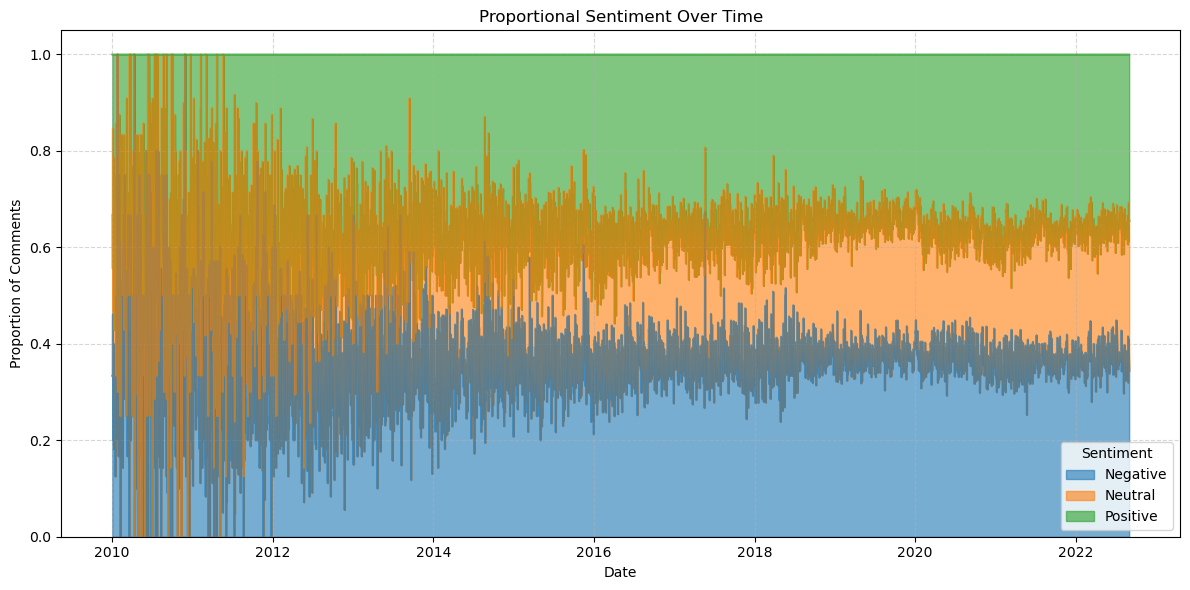

In [ ]:
sentiment_cols = ["Negative", "Neutral", "Positive"]
sentiment_only = pivoted[sentiment_cols]

# plot the normalized sentiment by day
normalized = sentiment_only.div(sentiment_only.sum(axis=1), axis=0)
normalized.plot(kind='area', stacked=True, figsize=(12, 6), alpha=0.6)
plt.title("Proportional Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Proportion of Comments")
plt.legend(title="Sentiment")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
dominant = pivoted[sentiment_cols].idxmax(axis=1)

# Count the number of days each sentiment was dominant
dominant_counts = dominant.value_counts()

print(dominant_counts)

Negative    2229
Positive    2148
Neutral      248
Name: count, dtype: int64


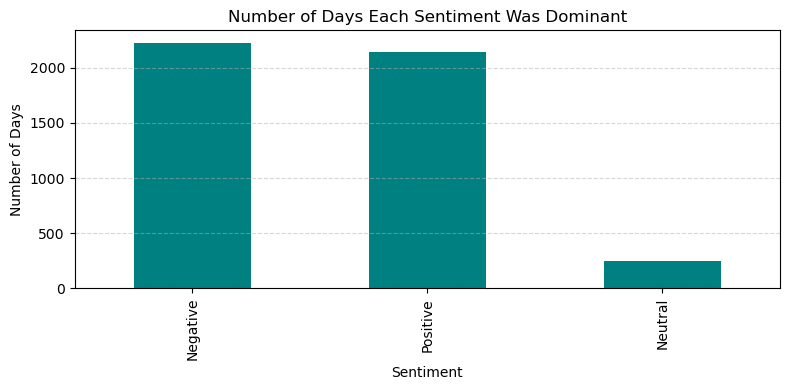

In [ ]:
# Plot the dominant days
dominant_counts.plot(kind='bar', color='teal', figsize=(8, 4))
plt.title("Number of Days Each Sentiment Was Dominant")
plt.xlabel("Sentiment")
plt.ylabel("Number of Days")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()